# Multivariate Time-Series Forecasting: Predict Iron Prices

### Import libs

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam



In [2]:
def pipeline(filename_str, first_layer_nodes, adam_learning_rate, drp1, drp2):
    # import training dataset
    filename_w_extension= filename_str+'.xlsx'
    filepath= r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated'+f'\{filename_w_extension}'
    dataset_train= pd.read_excel(filepath)
    element_name= dataset_train.pop('element_name')[0]
    dataset_train.columns = ['date','price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    dataset_train= dataset_train.sort_values(by=['date'], ascending=True)

    # features selection
    cols= list(dataset_train)[1:]

    # Extract dates (timestamp format)
    datelist_train = list(dataset_train['date'])
    
    # dataset_train.index= dataset_train.pop('date')
    print(dataset_train)
    print('Training set shape == {}'.format(dataset_train.shape))
    print('All timestamps == {}'.format(len(datelist_train)))
    print('Featured selected: {}'.format(cols))
    print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))
    


    # dataset training will be the essanse of all the upcoming datasets(training_set, training_set_scaled, X_train, y_train...)
    # make sure there are no commas in any number                                                      "Target"      |--------------------"Predictors"-------------------|
    dataset_train = dataset_train[cols].astype(str) # to remove the date and select only the features : ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    for i in cols:
        for j in range(0, len(dataset_train)):
            dataset_train[i][j] = dataset_train[i][j].replace(',', '')

    dataset_train = dataset_train.astype(float)

    # by using multiple predictors (features) we need to convert (reshape) to a matrix(array) using .to_numpy
    training_set= dataset_train.to_numpy()

    # Feature scaling hence features vary in range
    sc = StandardScaler()
    training_set_scaled = sc.fit_transform(training_set)

    sc_predict = StandardScaler()
    target_scaled= sc_predict.fit_transform(training_set[:, 0:1])

    print('Shape of training set        == {}.'.format(training_set.shape))
    print('Shape of training set scaled == {}.'.format(training_set_scaled.shape))

    # Create a data structure with timestamps
    # Target/features selection
    X_train= []
    y_train= []
    n_future= 6 # number of moths to be predicted
    n_past= 12 # the size of the windowed dataframe

    for i in range(n_past, len(training_set_scaled) - n_future +1):
        X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
        y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print('X_train shape == {}.'.format(X_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))



    # Generate list of sequence of months for predictions w datetime type
    datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
    datelist_future_= []
    for d in datelist_future:
        d= d + dt.timedelta(days=1)
        d= d.date()
        datelist_future_.append(d)
    datelist_future= datelist_future_
    del datelist_future_

    datelist_train_= []
    for this_timestamp in datelist_train:
        datelist_train_.append(this_timestamp.date())
    datelist_train= datelist_train_
    del datelist_train_



    # build the model
    model= Sequential()
    
    model.add(LSTM(units=first_layer_nodes, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
    model.add(Dropout(drp1))

    model.add(LSTM(units=first_layer_nodes//2, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
    model.add(Dropout(drp1))
    

    model.add(LSTM(units=10, return_sequences=False))
    model.add(Dropout(drp2))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer= Adam(learning_rate=adam_learning_rate), loss= 'mean_squared_error')
    # %%time
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    model_filepath= r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\models\{}'
    
    mcp = ModelCheckpoint(filepath=model_filepath.format(filename_str+'_weights.h5'), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')
    history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)



    # Perform predictions
    predictions_train = model.predict(X_train[n_past:])
    predictions_future = model.predict(X_train[-n_future:])

    y_pred_future = sc_predict.inverse_transform(predictions_future)
    y_pred_train = sc_predict.inverse_transform(predictions_train)

    # Prediction n_future
    # allocate original data point and predicted data point
    data_point_og= sc_predict.inverse_transform(target_scaled[-n_future:])
    data_point_predicted= y_pred_future
    # calculate the factor
    factor= (data_point_og[-1] - data_point_predicted[-1]) / data_point_predicted[-1]

    data_point_predicted_w_factor= (data_point_predicted * factor) + data_point_predicted
    # data_point_predicted_w_factor= data_point_predicted

    # Prediction
    # arr= np.array(data_point_predicted_w_factor)
    # for i in range(n_future):
    #     m= arr.mean()
    #     arr= np.append(arr, m)
    #     arr= np.delete(arr, 0)
    # data_point_predicted_w_factor= arr



    # Visualization
    training_start= 2 * n_past + n_future -1
    PREDICTIONS_FUTURE = pd.DataFrame(data_point_predicted_w_factor, columns=['predicted_forecast']).set_index(pd.Series(datelist_future))
    PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted_training']).set_index(pd.Series(datelist_train[training_start:]))

    dataset_train.index= datelist_train
    # Set plot size 
    from pylab import rcParams
    rcParams['figure.figsize'] = 14, 5

    # Plot parameters
    START_DATE_FOR_PLOTTING = '2013-01-01'

    plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['predicted_forecast'], color='r', label=f'{element_name}')
    plt.plot(PREDICTION_TRAIN.loc[:].index, PREDICTION_TRAIN.loc[:]['predicted_training'], color='r', label='Training predictions')
    plt.plot(dataset_train.loc[:].index, dataset_train.loc[:]['price'], color='b', label=f'Actual "{element_name}" Price')

    plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

    plt.grid(which='major', color='#cccccc', alpha=0.5)

    plt.legend(shadow=True)
    plt.title(f'Predcitions and Acutal: {element_name}', family='Arial', fontsize=12)
    plt.xlabel('Timeline', family='Arial', fontsize=10)
    plt.ylabel('Value', family='Arial', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.show()



    
    # final result to export
    df_price= pd.DataFrame(dataset_train.loc[:]['price'])
    df_price
    df_final_res = pd.merge(df_price, PREDICTION_TRAIN, how='left', left_index=True, right_index=True)
    df_final_res
    df_final_res= df_final_res.append(PREDICTIONS_FUTURE)
    df_final_res['element_name']= element_name


    file_location=  r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\output\construction materials price index prediction\{}'
    file_location= file_location.format(filename_w_extension)
    df_final_res.to_excel(file_location)
    
    return df_final_res

In [3]:
elements= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated\type names.xlsx')
elements.columns= ['element_name']

          date  price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  0.913     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  0.911     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  0.912     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  0.908     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  0.898     100.20   7,404.12  1,393.00           0.11   
..         ...    ...        ...        ...       ...            ...   
112 2022-05-01  1.180     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1.180     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1.180     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1.160      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1.110      85.14  11,405.32  1,672.00           2.56   

     historical  
0      0.819371  
1      0.913000  
2      0.911000  
3      0.912000  
4      0.908000  
..          ...  
112    1.

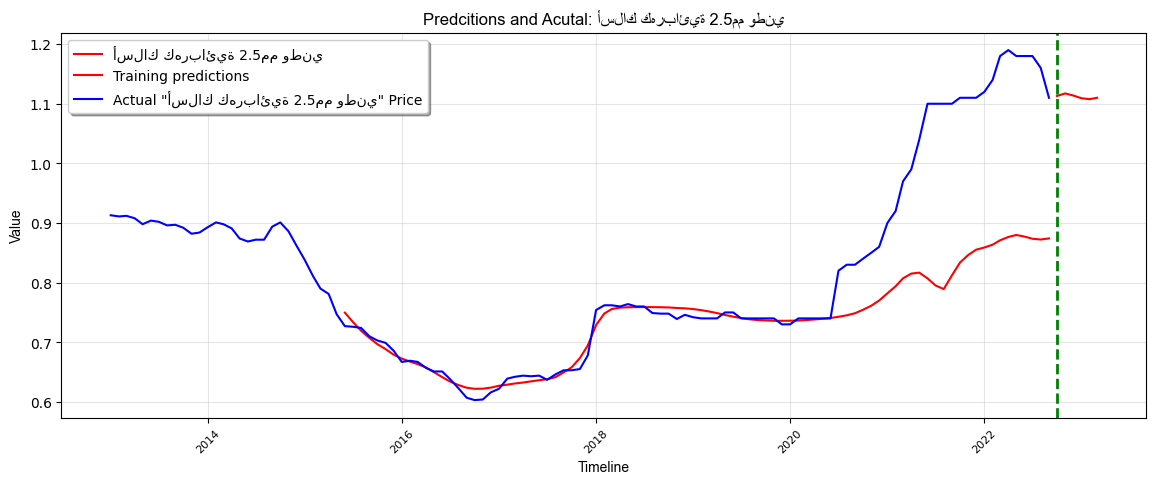

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11656\1929415924.py:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,0.913,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-02-01,0.911,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-03-01,0.912,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-04-01,0.908,NaN,NaN,أسلاك كهربائية 2.5مم وطني
2013-05-01,0.898,NaN,NaN,أسلاك كهربائية 2.5مم وطني
...,...,...,...,...
2022-11-01,NaN,NaN,1.117322,أسلاك كهربائية 2.5مم وطني
2022-12-01,NaN,NaN,1.113865,أسلاك كهربائية 2.5مم وطني
2023-01-01,NaN,NaN,1.109242,أسلاك كهربائية 2.5مم وطني
2023-02-01,NaN,NaN,1.107689,أسلاك كهربائية 2.5مم وطني


In [4]:
# أسلاك كهربائية 2.5مم وطني
pipeline('أسلاك كهربائية 2.5مم وطني', first_layer_nodes= 128, drp1= .015, drp2= .01, adam_learning_rate=.0015 )

          date  price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  1.384     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  1.364     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  1.378     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  1.369     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  1.369     100.20   7,404.12  1,393.00           0.11   
..         ...    ...        ...        ...       ...            ...   
112 2022-05-01  1.730     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1.740     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1.730     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1.700      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1.650      85.14  11,405.32  1,672.00           2.56   

     historical  
0      1.235138  
1      1.384000  
2      1.364000  
3      1.378000  
4      1.369000  
..          ...  
112    1.

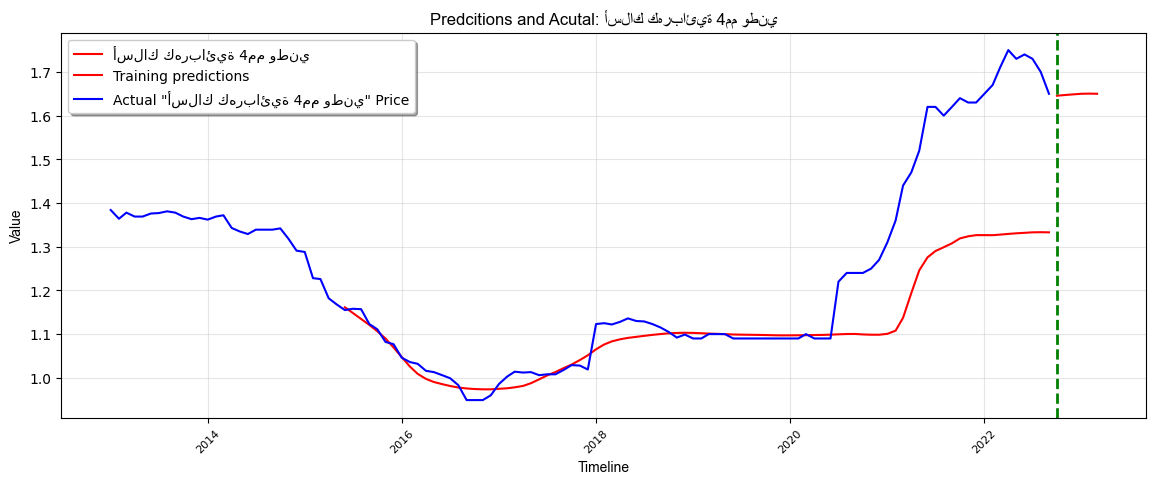

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18148\1929415924.py:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,1.384,NaN,NaN,أسلاك كهربائية 4مم وطني
2013-02-01,1.364,NaN,NaN,أسلاك كهربائية 4مم وطني
2013-03-01,1.378,NaN,NaN,أسلاك كهربائية 4مم وطني
2013-04-01,1.369,NaN,NaN,أسلاك كهربائية 4مم وطني
2013-05-01,1.369,NaN,NaN,أسلاك كهربائية 4مم وطني
...,...,...,...,...
2022-11-01,NaN,NaN,1.647238,أسلاك كهربائية 4مم وطني
2022-12-01,NaN,NaN,1.648609,أسلاك كهربائية 4مم وطني
2023-01-01,NaN,NaN,1.650012,أسلاك كهربائية 4مم وطني
2023-02-01,NaN,NaN,1.650359,أسلاك كهربائية 4مم وطني


In [19]:
# أسلاك كهربائية 4مم وطني
pipeline('أسلاك كهربائية 4مم وطني', first_layer_nodes= 128, drp1= .015, drp2= .01, adam_learning_rate=.005 )

          date  price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2.045     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2.039     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2.050     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2.021     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2.018     100.20   7,404.12  1,393.00           0.11   
..         ...    ...        ...        ...       ...            ...   
112 2022-05-01  2.600     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  2.610     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  2.610     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  2.560      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  2.530      85.14  11,405.32  1,672.00           2.56   

     historical  
0      1.865328  
1      2.045000  
2      2.039000  
3      2.050000  
4      2.021000  
..          ...  
112    2.

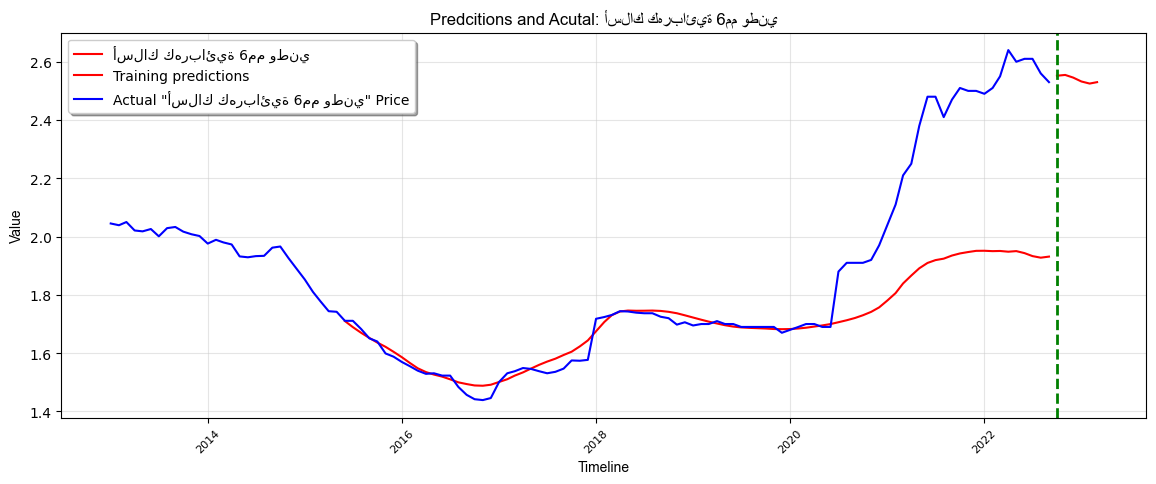

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18148\1929415924.py:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,2.045,NaN,NaN,أسلاك كهربائية 6مم وطني
2013-02-01,2.039,NaN,NaN,أسلاك كهربائية 6مم وطني
2013-03-01,2.050,NaN,NaN,أسلاك كهربائية 6مم وطني
2013-04-01,2.021,NaN,NaN,أسلاك كهربائية 6مم وطني
2013-05-01,2.018,NaN,NaN,أسلاك كهربائية 6مم وطني
...,...,...,...,...
2022-11-01,NaN,NaN,2.554713,أسلاك كهربائية 6مم وطني
2022-12-01,NaN,NaN,2.545659,أسلاك كهربائية 6مم وطني
2023-01-01,NaN,NaN,2.532256,أسلاك كهربائية 6مم وطني
2023-02-01,NaN,NaN,2.525146,أسلاك كهربائية 6مم وطني


In [27]:
# أسلاك كهربائية 6مم وطني
pipeline('أسلاك كهربائية 6مم وطني', first_layer_nodes= 128, drp1= .02, drp2= .01, adam_learning_rate=.0055 )

          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  66.612     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  66.375     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  66.521     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  66.285     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  66.562     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  94.880     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  92.360     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  89.610     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  90.030      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  90.050      85.14  11,405.32  1,672.00           2.56   

     historical  
0     69.140017  
1     66.612000  
2     66.375000  
3     66.521000  
4     66.285000  
..          ...

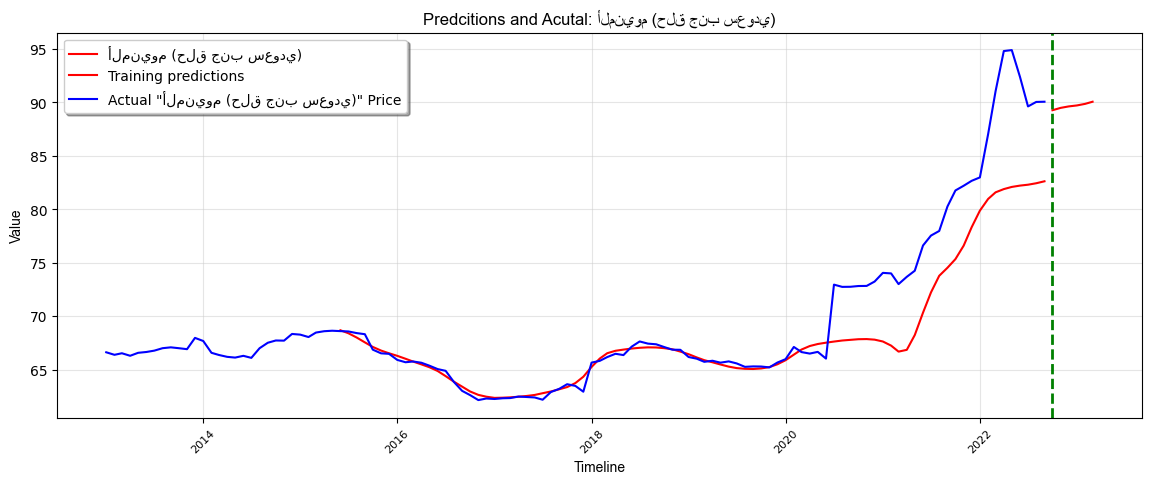

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18148\1929415924.py:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,66.612,NaN,NaN,ألمنيوم (حلق جنب سعودي)
2013-02-01,66.375,NaN,NaN,ألمنيوم (حلق جنب سعودي)
2013-03-01,66.521,NaN,NaN,ألمنيوم (حلق جنب سعودي)
2013-04-01,66.285,NaN,NaN,ألمنيوم (حلق جنب سعودي)
2013-05-01,66.562,NaN,NaN,ألمنيوم (حلق جنب سعودي)
...,...,...,...,...
2022-11-01,NaN,NaN,89.475141,ألمنيوم (حلق جنب سعودي)
2022-12-01,NaN,NaN,89.610622,ألمنيوم (حلق جنب سعودي)
2023-01-01,NaN,NaN,89.701558,ألمنيوم (حلق جنب سعودي)
2023-02-01,NaN,NaN,89.850288,ألمنيوم (حلق جنب سعودي)


In [38]:
# ألمنيوم (حلق جنب سعودي)
pipeline('ألمنيوم (حلق جنب سعودي)', first_layer_nodes= 128, drp1= .015, drp2= .01, adam_learning_rate=.0055 )

          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  15.181     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  15.335     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  16.053     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  15.955     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  16.057     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  14.470     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  14.850     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  14.790     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  14.640      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  14.330      85.14  11,405.32  1,672.00           2.56   

     historical  
0     14.089526  
1     15.181000  
2     15.335000  
3     16.053000  
4     15.955000  
..          ...

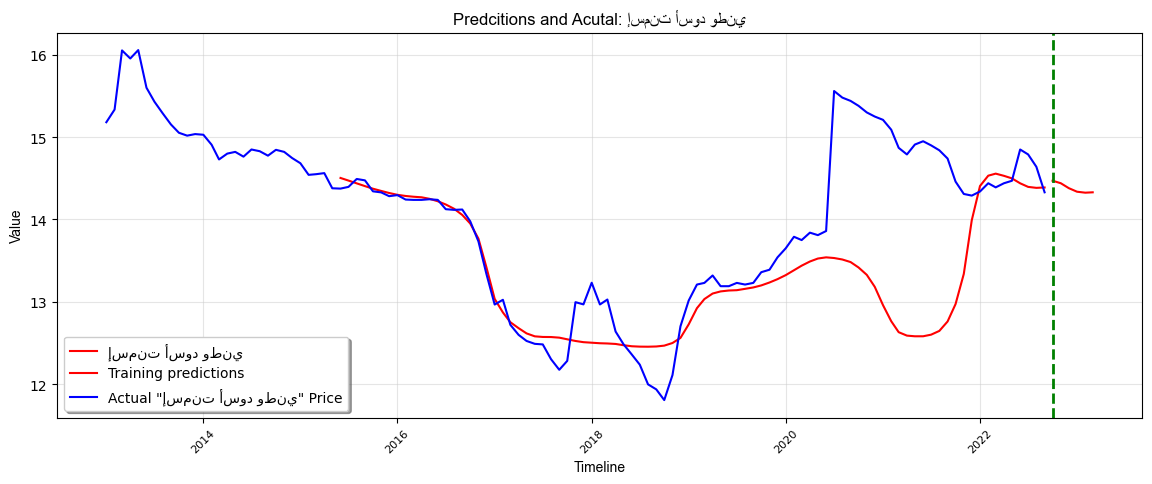

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18148\1929415924.py:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,15.181,NaN,NaN,إسمنت أسود وطني
2013-02-01,15.335,NaN,NaN,إسمنت أسود وطني
2013-03-01,16.053,NaN,NaN,إسمنت أسود وطني
2013-04-01,15.955,NaN,NaN,إسمنت أسود وطني
2013-05-01,16.057,NaN,NaN,إسمنت أسود وطني
...,...,...,...,...
2022-11-01,NaN,NaN,14.440170,إسمنت أسود وطني
2022-12-01,NaN,NaN,14.380569,إسمنت أسود وطني
2023-01-01,NaN,NaN,14.337178,إسمنت أسود وطني
2023-02-01,NaN,NaN,14.325439,إسمنت أسود وطني


In [42]:
# إسمنت أسود وطني
pipeline('إسمنت أسود وطني', first_layer_nodes= 128, drp1= .015, drp2= .015, adam_learning_rate=.005 )

          date   price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  40.191     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  39.886     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  40.096     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  40.100     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  40.079     100.20   7,404.12  1,393.00           0.11   
..         ...     ...        ...        ...       ...            ...   
112 2022-05-01  39.110     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  39.460     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  39.200     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  39.170      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  38.960      85.14  11,405.32  1,672.00           2.56   

     historical  
0     39.951181  
1     40.191000  
2     39.886000  
3     40.096000  
4     40.100000  
..          ...

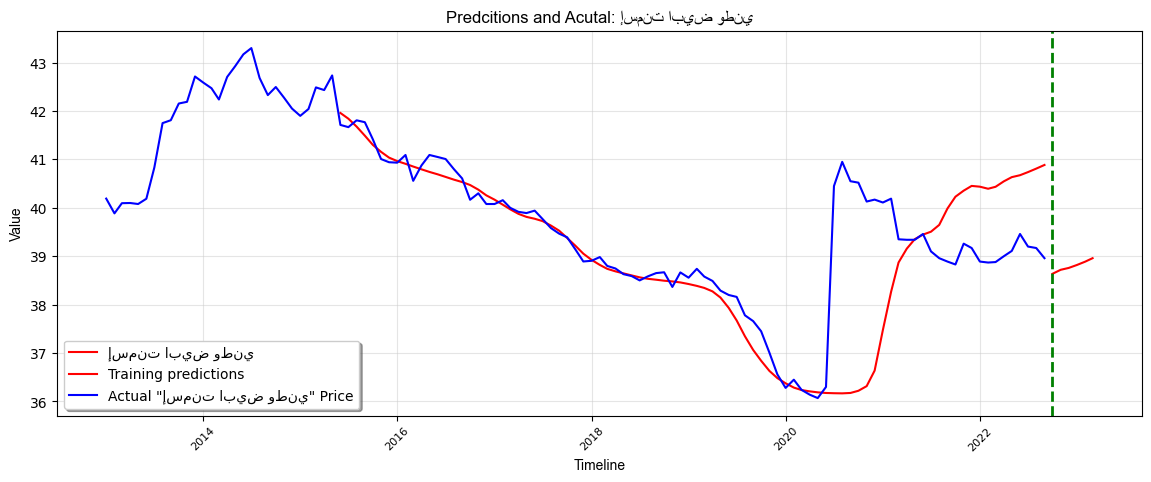

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18148\1929415924.py:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,40.191,NaN,NaN,إسمنت ابيض وطني
2013-02-01,39.886,NaN,NaN,إسمنت ابيض وطني
2013-03-01,40.096,NaN,NaN,إسمنت ابيض وطني
2013-04-01,40.100,NaN,NaN,إسمنت ابيض وطني
2013-05-01,40.079,NaN,NaN,إسمنت ابيض وطني
...,...,...,...,...
2022-11-01,NaN,NaN,38.720097,إسمنت ابيض وطني
2022-12-01,NaN,NaN,38.758257,إسمنت ابيض وطني
2023-01-01,NaN,NaN,38.819343,إسمنت ابيض وطني
2023-02-01,NaN,NaN,38.887958,إسمنت ابيض وطني


In [53]:
# إسمنت ابيض وطني
pipeline('إسمنت ابيض وطني', first_layer_nodes= 128, drp1= .015, drp2= .02, adam_learning_rate=.0055 )

          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  1670.354     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  1668.103     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  1685.345     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  1693.534     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  1697.845     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  1761.660     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1763.190     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1766.020     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1766.480      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1757.290      85.14  11,405.32  1,672.00           2.56   

      historical  
0    1580.877043  
1    1670.354000  
2    1668.103000  
3    1685.345000  
4   

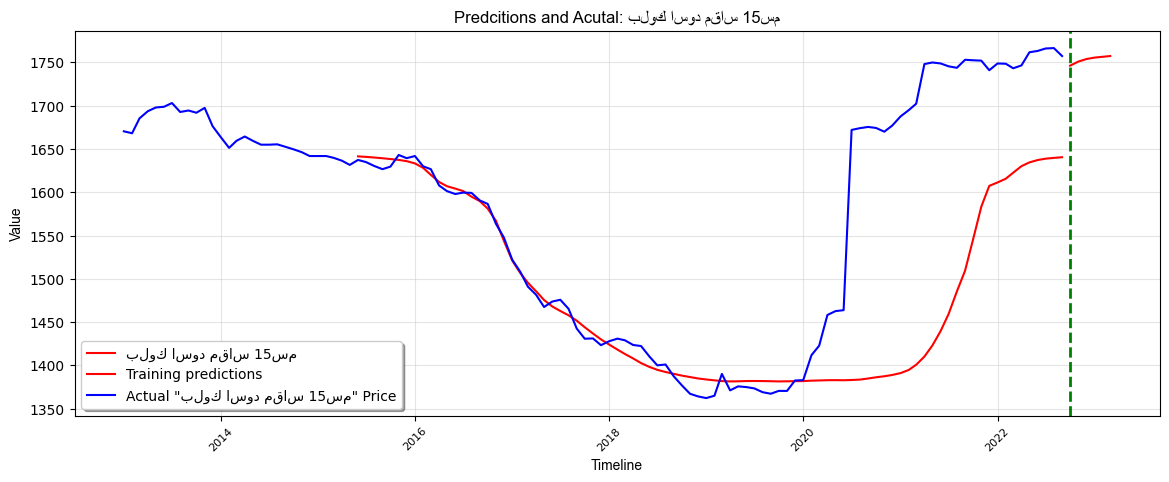

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18148\1929415924.py:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,1670.354,NaN,NaN,بلوك اسود مقاس 15سم
2013-02-01,1668.103,NaN,NaN,بلوك اسود مقاس 15سم
2013-03-01,1685.345,NaN,NaN,بلوك اسود مقاس 15سم
2013-04-01,1693.534,NaN,NaN,بلوك اسود مقاس 15سم
2013-05-01,1697.845,NaN,NaN,بلوك اسود مقاس 15سم
...,...,...,...,...
2022-11-01,NaN,NaN,1750.873101,بلوك اسود مقاس 15سم
2022-12-01,NaN,NaN,1753.781183,بلوك اسود مقاس 15سم
2023-01-01,NaN,NaN,1755.492635,بلوك اسود مقاس 15سم
2023-02-01,NaN,NaN,1756.440551,بلوك اسود مقاس 15سم


In [54]:
# بلوك اسود مقاس 15سم
pipeline('بلوك اسود مقاس 15سم', first_layer_nodes= 128, drp1= .01, drp2= .01, adam_learning_rate=.005 )

          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  1768.534     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  1775.000     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  1784.583     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  1797.500     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  1800.417     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  1855.250     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  1855.250     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  1857.910     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  1857.500      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  1833.140      85.14  11,405.32  1,672.00           2.56   

      historical  
0    1664.218621  
1    1768.534000  
2    1775.000000  
3    1784.583000  
4   

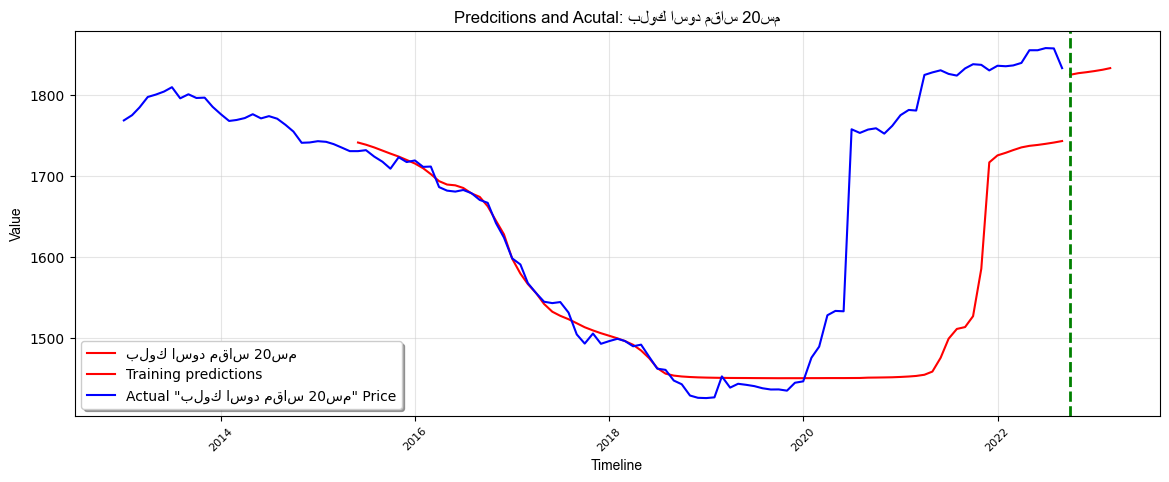

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18148\1929415924.py:168: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,1768.534,NaN,NaN,بلوك اسود مقاس 20سم
2013-02-01,1775.000,NaN,NaN,بلوك اسود مقاس 20سم
2013-03-01,1784.583,NaN,NaN,بلوك اسود مقاس 20سم
2013-04-01,1797.500,NaN,NaN,بلوك اسود مقاس 20سم
2013-05-01,1800.417,NaN,NaN,بلوك اسود مقاس 20سم
...,...,...,...,...
2022-11-01,NaN,NaN,1826.898503,بلوك اسود مقاس 20سم
2022-12-01,NaN,NaN,1828.079223,بلوك اسود مقاس 20سم
2023-01-01,NaN,NaN,1829.516576,بلوك اسود مقاس 20سم
2023-02-01,NaN,NaN,1831.191691,بلوك اسود مقاس 20سم


In [55]:
# بلوك اسود مقاس 20سم
pipeline('بلوك اسود مقاس 20سم', first_layer_nodes= 128, drp1= .01, drp2= .01, adam_learning_rate=.005 )

In [ ]:
# حديد تسليح 12مم وطني'
pipeline('حديد تسليح 12مم وطني', first_layer_nodes= 128, drp1= .015, drp2= .01, adam_learning_rate=.005 )